<a href="https://colab.research.google.com/github/ryzhokhina/Tensorflow-Dev-Exam-Preparation/blob/main/07_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

What we're going to cover
1. Using TensorFlow Datasets to download and explore data
2. Creating preprocessing function for our data
3. Batching & preparing datasets for modelling (making our datasets run fast)
4. Creating modelling callbacks
5. Setting up mixed precision training
6. Building a feature extraction model (see transfer learning part 1: feature extraction)
7. Fine-tuning the feature extraction model (see transfer learning part 2: fine-tuning)
8. Viewing training results on TensorBoard

In [6]:
# Install tf-nightly (required until 2.13.0+ is the default in Google Colab)
#!pip install -U -q tf-nightly

# Check TensorFlow version (should be minimum 2.4.0+ but 2.13.0+ is better)
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Add timestamp
import datetime
print(f"Notebook last run (end-to-end): {datetime.datetime.now()}")

TensorFlow version: 2.13.0
Notebook last run (end-to-end): 2023-07-13 17:17:23.120419


In [7]:
#!pip install tensorflow==2.13.0


In [8]:
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [9]:
ds_list = tfds.list_builders()

In [10]:
len(ds_list)


1143

In [11]:
data_food_name = "food101"
print("Is your dataset in tensorflow_datasets:", data_food_name in ds_list)

Is your dataset in tensorflow_datasets: True


# Load data

In [12]:
(train_data, val_data), ds_info = tfds.load(
    name=data_food_name,
    split=['train', 'validation'],
    shuffle_files=True,
    with_info=True,
    as_supervised= True)



In [13]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [14]:
class_names = ds_info.features["label"].names
num_classes = ds_info.features["label"].num_classes

print(num_classes)

101


In [15]:
ds_info.splits['train'].num_examples

75750

In [16]:
ds_info.splits['validation'].num_examples

25250

In [17]:
t = train_data.take(1)

(512, 512, 3)
255
0
baby_back_ribs


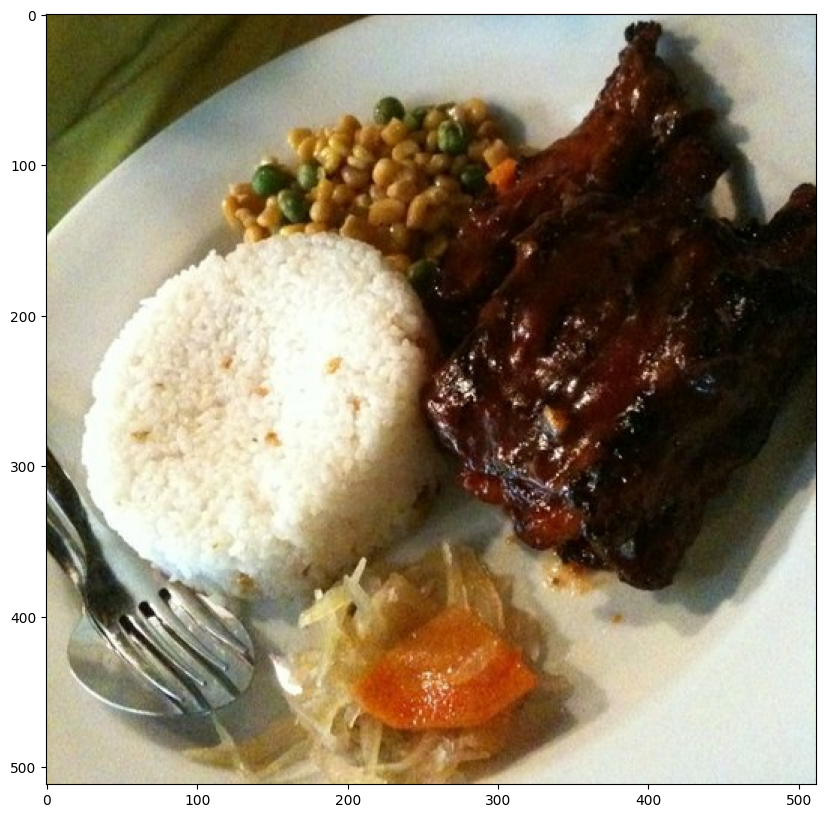

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for image, label in t:
    print(image.shape)
    print(tf.math.reduce_max(image).numpy() )
    print(tf.math.reduce_min(image).numpy() )
    print(class_names[label.numpy()])
    plt.imshow(image)
    plt.show()
    break



# Preprocessing data

In [19]:
def preprocess_image(image, label, img_shape=224):
    image = tf.image.resize(image, [img_shape, img_shape])
    return tf.cast(image, tf.float32), label
#

(512, 512, 3)
(224, 224, 3)
churros


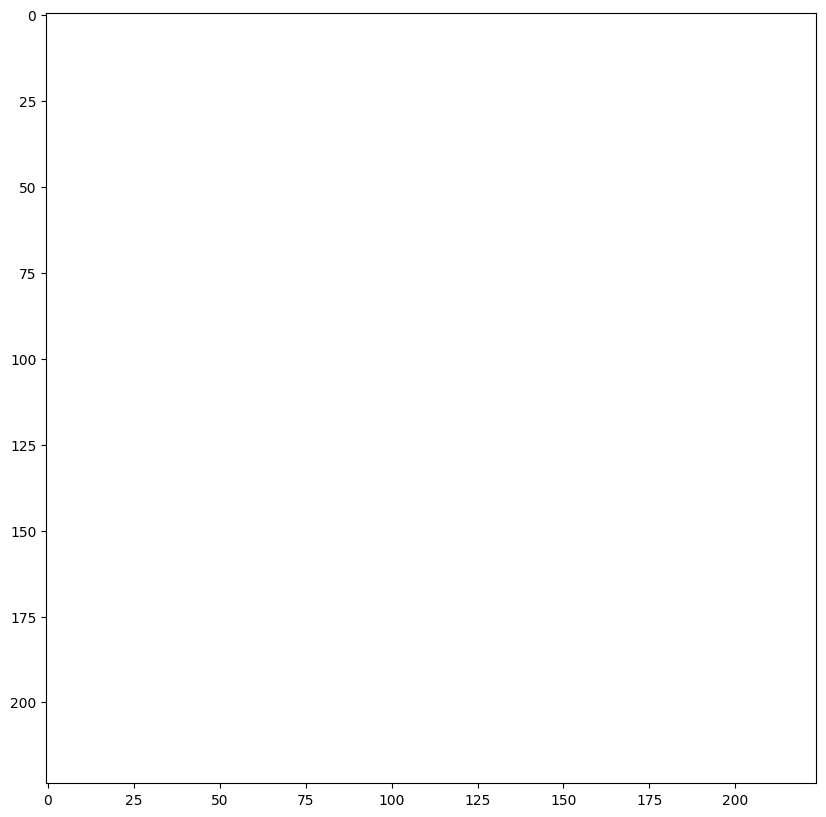

In [20]:
plt.figure(figsize=(10,10))
for image, label in t:
    print(image.shape)
    image,_ = preprocess_image(image, label)
    print(image.shape)
    print(class_names[label.numpy()])
    plt.imshow(image)
    plt.show()
    break

In [21]:
train_data=train_data \
          .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
          .shuffle(1000) \
          .batch(32) \
          .prefetch(tf.data.AUTOTUNE)


val_data = val_data\
            .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE) \
            .batch(32) \
            .prefetch(tf.data.AUTOTUNE)

In [22]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

#Create modelling callbacks

In [23]:
MCP = tf.keras.callbacks.ModelCheckpoint(
    filepath="model1_check_point",
    save_weights_only=True,
    monitor="val_accuracy",
    save_best_only=False,
    verbose=1,
)

In [24]:
ES = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=3,
    verbose=1,
    restore_best_weights=True,
)


In [25]:
RLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.2,
    patience=2,
    verbose=1,
    min_lr=1e-7)

# Extract features from existiong model
Create a base model

In [26]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

In [27]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [28]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet')
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype = tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [29]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [30]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 129381 (505.39 KB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [31]:
history = model.fit(train_data, epochs=5, validation_data=val_data, callbacks=[MCP])


Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.7190 - accuracy: 0.5804
Epoch 1: saving model to model1_check_point
2368/2368 [==============================] - 144s 54ms/step - loss: 1.7190 - accuracy: 0.5804 - val_loss: 1.1357 - val_accuracy: 0.6983
Epoch 2/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.2008 - accuracy: 0.6880
Epoch 2: saving model to model1_check_point
2368/2368 [==============================] - 126s 53ms/step - loss: 1.2008 - accuracy: 0.6880 - val_loss: 1.0339 - val_accuracy: 0.7213
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.0556 - accuracy: 0.7221
Epoch 3: saving model to model1_check_point
2368/2368 [==============================] - 127s 53ms/step - loss: 1.0556 - accuracy: 0.7221 - val_loss: 0.9945 - val_accuracy: 0.7302
Epoch 4/5
2368/2368 [==============================] - ETA: 0s - loss: 0.9604 - accuracy: 0.7467
Epoch 4: saving model to model1_check_point
2368/2368 [=================

In [32]:
import pandas as pd

def plot_history(history):
  plt.figure(figsize=(12,12))
  plt.subplot(2,1,1)
  plt.title('accuracy')
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.subplot(2,1,2)
  plt.title('loss')
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()



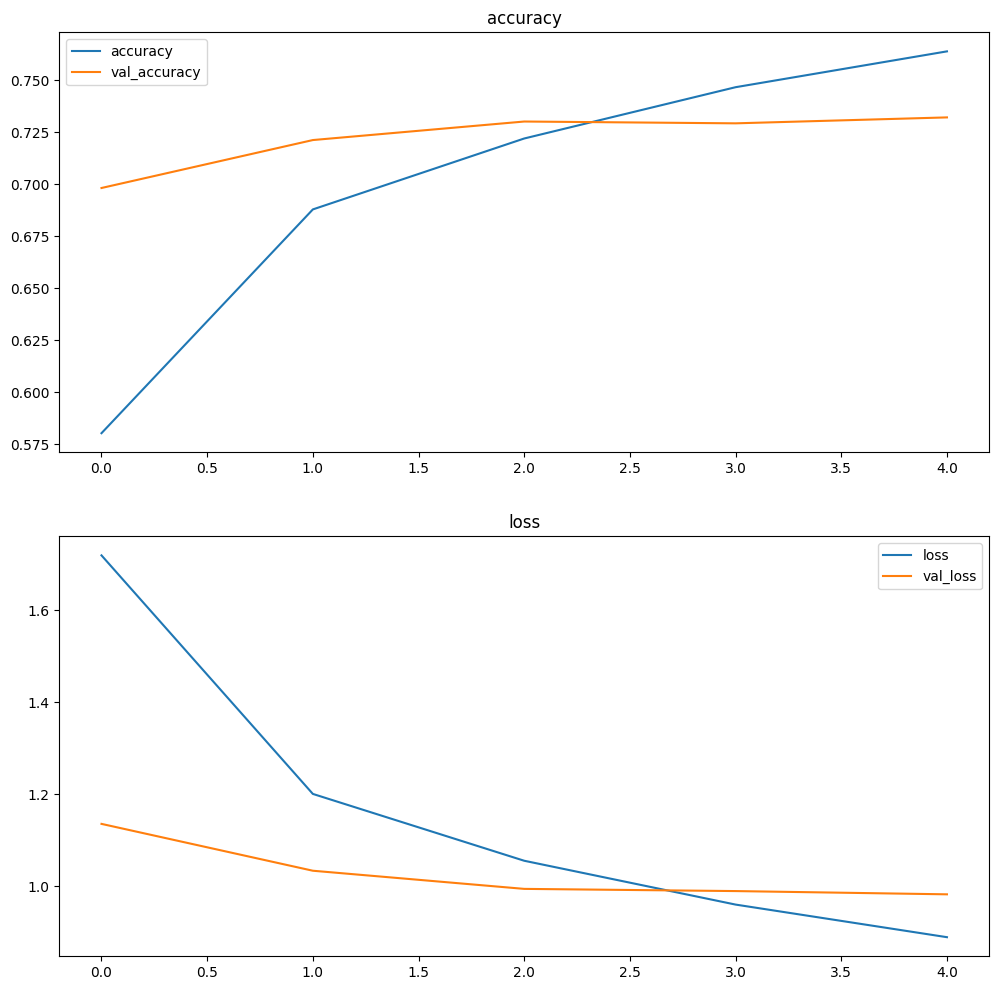

In [33]:
plot_history(history)


In [34]:
model.evaluate(val_data)

790/790 [==============================] - 29s 36ms/step - loss: 0.9827 - accuracy: 0.7322


[0.9826741814613342, 0.7321979999542236]

## Tuning model

In [35]:
# turn on learning for all layres
for l in model.layers:
  print(l.name, l.trainable)
  l.trainable = True
model.summary()


input_layer True
efficientnetb0 False
global_average_pooling2d True
dense True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
Total params: 4178952 (15.94 MB)
Trainable params: 4136929 (15.78 MB)
Non-trainable params: 42023 (164.14 KB)
____

In [36]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)



In [38]:
model.fit(train_data,
          epochs=100,
          validation_data = val_data,
          validation_steps = int(0.15*len(val_data)),
          callbacks = [ES, RLR, MCP])


Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 0.7961 - accuracy: 0.7823
Epoch 1: saving model to model1_check_point
2368/2368 [==============================] - 379s 137ms/step - loss: 0.7961 - accuracy: 0.7823 - val_loss: 0.8034 - val_accuracy: 0.7712 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.8662
Epoch 2: saving model to model1_check_point
2368/2368 [==============================] - 324s 136ms/step - loss: 0.4766 - accuracy: 0.8662 - val_loss: 0.7902 - val_accuracy: 0.7802 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.9253
Epoch 3: saving model to model1_check_point
2368/2368 [==============================] - 324s 136ms/step - loss: 0.2619 - accuracy: 0.9253 - val_loss: 0.8842 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1445 - accuracy: 0.9569
Epoch 4: s

In [39]:
model.evaluate(val_data)

790/790 [==============================] - 29s 37ms/step - loss: 1.1683 - accuracy: 0.8048


[1.1682898998260498, 0.8047921061515808]

#Save model

In [ ]:
tf.__version__

In [40]:
model.save("new_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [41]:
saved_model = tf.keras.models.load_model("new_model.h5")


In [ ]:
saved_model.evaluate(val_data)


790/790 [==============================] - 32s 38ms/step - loss: 1.1683 - accuracy: 0.8048
